In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

### 1. Spark Cluster Ayağa Kaldırma

In [ ]:
spark = (
    SparkSession.builder
    .appName("ML-Training")                  # Uygulama adı
    .master("spark://10.0.0.4:7077")         # 10.0.0.4 adresi master node'un private IP'sidir
    .config("spark.executor.memory", "2g")   # Worker başına 2 GB RAM ayır
    .config("spark.executor.cores", "2")     # Worker başına 2 çekirdek ayır
    .config("spark.cores.max", "4")          # Maksimum 4 çekirdek kullan
    .config("spark.driver.host", "10.0.0.4") # Driver Master makinesinde çalışacaktır
    .config("spark.driver.port", "7378")     # Master ve Worker makineler arası haberleşme portu
    .getOrCreate()
)


print(f"✓ Connected to Spark {spark.version}")
print(f"✓ Master: {spark.sparkContext.master}")
print(f"✓ App ID: {spark.sparkContext.applicationId}")
print(f"✓ Web UI: http://localhost:4040")

25/12/08 19:26:12 WARN Utils: Your hostname, ubuntu-4gb-nbg1-dokploy resolves to a loopback address: 127.0.1.1; using 46.224.54.137 instead (on interface eth0)
25/12/08 19:26:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/08 19:26:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✓ Connected to Spark 3.5.7
✓ Master: spark://10.0.0.4:7077
✓ App ID: app-20251208192614-0001
✓ Web UI: http://localhost:4040



#### 1.1 Spark Cluster Diyagramı

# <img src="img/spark_cluster_diagram.png" width="75%">

* Spark dağıtık mimaride diyagramdaki gibi çalışmaktadır. Spark uygulamasının beyni olan Driver master makinede çalışır ve uygulamadaki işleri planlar ve kaynak istenimini sağlar
* Cluster Manager, yani master makinesi işler esnasında hangi worker'da ne kadar kaynak ayrılacağını yönetir
* Worker node ise işlemlerin çalıştığı makinelerdir

#### 1.2 Spark Web UI

# <img src="img/spark_ui_8080.png" width="75%">

Bu çalışmada 2 adet worker makinesi kullanılmıştır ve her birinden 2 adet işlemci çekirdeği ve 2 GB RAM ayrılmıştır

### 2. Veri Setinin Hazırlanması

Bu çalışmada popüler çalışma veri setlerinden olan breast cancer veri seti kullanılacaktır ([link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html))

In [9]:
breast_cancer = load_breast_cancer(as_frame=True)
breast_cancer_df = breast_cancer["frame"]
breast_cancer_df = spark.createDataFrame(breast_cancer_df)
breast_cancer_df.show(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 3. Veri İşleme

Veri setinde herhangi bir ön işleme ihtiyacı bulunmamaktadır, bu nedenle direkt olarak %80 eğitim, %20 test veri seti olacak şekilde 2 ayrı kümeye ayrılmaktadır

In [ ]:
# All columns except 'target' are features
feature_cols = [c for c in breast_cancer_df.columns if c != "target"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [ ]:
train_df, test_df = breast_cancer_df.randomSplit([0.8, 0.2], seed=42)
print(f"Train rows: {train_df.count()}, Test rows: {test_df.count()}")

Train rows: 456, Test rows: 113


### 4. Modelleme

Modellemede en temel makine öğrenmesi modellerinden biri olan lojistik regresyon kullanılmıştır

In [58]:
log_reg = LogisticRegression(
    featuresCol="features",
    labelCol="target"
)

pipeline = Pipeline(stages=[assembler, log_reg])

In [59]:
model = pipeline.fit(train_df)

### 5. Model Değerlendirme

In [60]:
predictions = model.transform(test_df)
predictions.select("target", "probability", "prediction").show(20, truncate=False)

+------+----------------------------+----------+
|target|probability                 |prediction|
+------+----------------------------+----------+
|1     |[0.0,1.0]                   |1.0       |
|1     |[0.0,1.0]                   |1.0       |
|1     |[0.0,1.0]                   |1.0       |
|1     |[0.0,1.0]                   |1.0       |
|1     |[0.0,1.0]                   |1.0       |
|0     |[1.0,0.0]                   |0.0       |
|1     |[0.0,1.0]                   |1.0       |
|1     |[0.0,1.0]                   |1.0       |
|0     |[1.0,0.0]                   |0.0       |
|0     |[2.3035802572569723E-24,1.0]|1.0       |
|1     |[0.0,1.0]                   |1.0       |
|0     |[1.0,0.0]                   |0.0       |
|1     |[0.0,1.0]                   |1.0       |
|0     |[1.0,0.0]                   |0.0       |
|0     |[1.0,0.0]                   |0.0       |
|0     |[1.0,0.0]                   |0.0       |
|0     |[4.4591114554180704E-46,1.0]|1.0       |
|0     |[1.0,0.0]   

Model değerlendirme metriği olarak en popüler metrikler olan:
* **Accuracy:** Modelin sınıf dağılımı farketmeksizin genel doğruluğu
* **Precision:** Pozitif sınıf tahminlerin gerçekten ne kadarının pozitif sınıfa ait olduğu
* **Recall:** Poziif sınıflardan ne kadarının yakalanabildiği
* **F1-Score:** Precision ve Recall arasındaki dengeyi
* **ROC-AUC:** Farklı threshold değerleri boyunca sınıfları ayırt etme gücü

metrikleri kullanılmıştır. <br>

Bu çalışma özelinde pozitif veya negatif sınıf arasında herhangi bir önem farkı olmadığı varsayılmıştır.

In [ ]:
# Accuracy
acc_eval = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="accuracy",
)
accuracy = acc_eval.evaluate(predictions)

# Precision
prec_eval = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="weightedPrecision",
)
precision = prec_eval.evaluate(predictions)

# Recall
rec_eval = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="weightedRecall",
)
recall = rec_eval.evaluate(predictions)

# F1-score
f1_eval = MulticlassClassificationEvaluator(
    labelCol="target",
    predictionCol="prediction",
    metricName="f1",
)
f1 = f1_eval.evaluate(predictions)

# ROC–AUC
auc_eval = BinaryClassificationEvaluator(
    labelCol="target",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC",
)
auc = auc_eval.evaluate(predictions)

metrics = {
    "Accuracy": accuracy,
    "F1-Score": f1,
    "Precision": precision,
    "Recall": recall,
    "ROC-AUC": auc,
}

metrics_df = pd.DataFrame(
    {
        "Metric": list(metrics.keys()),
        "Value": [metrics[m] for m in metrics],
    }
)

In [ ]:
metrics_df.head()

,Metric,Value
0,Accuracy,0.938053
1,F1-Score,0.938636
2,Precision,0.940644
3,Recall,0.938053
4,ROC-AUC,0.996088


Modelin çeşitli metriklerde performansının %90 üzerine çıktığı görülmektedir, modelin başarılı bir model olduğu söyleyebilir

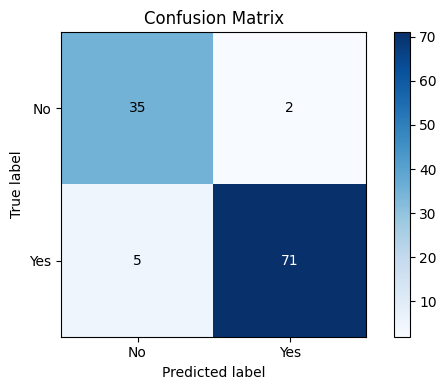

In [ ]:
class_labels = ["No", "Yes"]

pdf = predictions.select("target", "prediction").toPandas()
cm = confusion_matrix(pdf["target"], pdf["prediction"], labels=[0.0, 1.0])

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_labels,
    yticklabels=class_labels,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix",
)

# Annotate each cell with count
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.tight_layout()
plt.show()

### 6. Sonuç

Spark, dağıtık mimaride veri işleme, streaming yapma ve model eğitimi için en çok kullanılan teknolojilerden biridir. <br> <br>
Fakat on-prem bir şekilde, farklı bir değişle kendi makineleriniz vasıtasıyla cluster kurmak ve yönetmek; sistem, network, siber güvenlik ve çeşitli alanlarda yetkinlik istemekle beraber sürdürülebilmesi de ek zaman eforu istemektedir. Bu nedenle dağıtık mimari çözümlerini AWS, Google Cloud, Azure gibi bulut çözümler vasıtasıyla uygulamak daha kolay ve güvenli olacaktır. <br> <br>
Örnek vermek gerekirse, AWS tarafında SageMaker, model eğitimi ve testleri için oldukça popüler bir araçtır. "Kullandığın kadar öde" mantığı ile saatlik şekilde kullanılacak makine türüne göre ücretlendirme yapmaktadır.